In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

In [7]:
from pathlib import Path

# Resolve project root (works regardless of notebook kernel cwd)
def get_project_root():
    p = Path.cwd()
    for _ in range(6):
        if (p / "environment.yml").exists() or (p / "README.md").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd()

PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / "data" / "processed"

gdelt = pd.read_csv(DATA_DIR / "gdelt_articles_accumulated.csv", parse_dates=["seendate"])
ohlcv = pd.read_csv(DATA_DIR / "prices_daily_accumulated.csv", parse_dates=["date"])

print("GDELT:", gdelt.shape)
print("OHLCV:", ohlcv.shape)

GDELT: (381, 8)
OHLCV: (175, 8)


In [ ]:
# Confirms and displays number of unique days for gdelt articles
gdelt["seendate"] = pd.to_datetime(gdelt["seendate"], errors="coerce")

print("rows:", len(gdelt))
print("null seendate:", gdelt["seendate"].isna().sum())
print("min:", gdelt["seendate"].min())
print("max:", gdelt["seendate"].max())

# how many unique days?
days = gdelt["seendate"].dt.floor("D")
print("unique days:", days.nunique())

# show top days by article count
print(days.value_counts().head(10))

rows: 381
null seendate: 0
min: 2026-01-27 05:15:00+00:00
max: 2026-02-03 20:15:00+00:00
unique days: 4
seendate
2026-01-27 00:00:00+00:00    131
2026-02-03 00:00:00+00:00    131
2026-02-01 00:00:00+00:00    101
2026-02-02 00:00:00+00:00     18
Name: count, dtype: int64


In [9]:
# gdelt.groupby(gdelt["seendate"].dt.to_period("D")).size().plot(
#     figsize=(14, 4),
#     title="GDELT Articles per Day"
# )

# gdelt.groupby(gdelt["seendate"].dt.to_period("D")).size() \
#      .rename_axis("date") \
#      .reset_index(name="count") \
#      .assign(date=lambda df: df["date"].dt.to_timestamp()) \
#      .set_index("date")["count"] \
#      .plot(figsize=(14, 4))


Text(0, 0.5, 'articles')

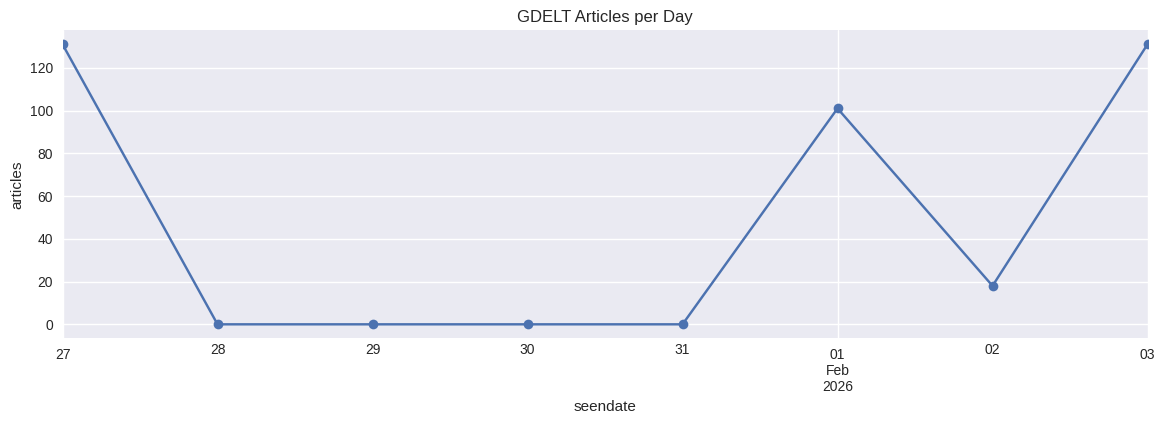

In [10]:
# Case of 1 unique day
ts = gdelt.set_index("seendate").resample("D").size()

ax = ts.plot(figsize=(14,4), marker="o", title="GDELT Articles per Day")
ax.set_ylabel("articles")


## Friday vs Monday price behavior

**Assumption:** We assume the "weekend effect" (prices tending to rise on Friday and drop on Monday) still applies to the **MAG7 subset** of tickers we are investigating (AAPL, MSFT, NVDA, GOOGL, AMZN, META, TSLA). See `docs/weekend_effect_analysis.md`.

We use daily returns (open→close and close→close) by weekday and compare average Friday vs Monday returns across MAG7 tickers and time to check whether this pattern is visible in our sample.

In [11]:
# Daily return: (close - open) / open for same-day move; then we can also do (close - prev_close)/prev_close for overnight/weekend
ohlcv["date"] = pd.to_datetime(ohlcv["date"], errors="coerce")
ohlcv = ohlcv.sort_values(["ticker", "date"]).reset_index(drop=True)

# Same-day return (open -> close)
ohlcv["return_open_close"] = (ohlcv["close"] - ohlcv["open"]) / ohlcv["open"]

# Previous close to this close (captures overnight + same-day; Monday will include weekend)
ohlcv["prev_close"] = ohlcv.groupby("ticker")["close"].shift(1)
ohlcv["return_close_to_close"] = (ohlcv["close"] - ohlcv["prev_close"]) / ohlcv["prev_close"]

ohlcv["weekday"] = ohlcv["date"].dt.dayofweek  # 0=Mon, 4=Fri
ohlcv["weekday_name"] = ohlcv["date"].dt.day_name()

print("Weekday codes: 0=Monday, 4=Friday")
print(ohlcv[["date", "ticker", "open", "close", "return_open_close", "return_close_to_close", "weekday_name"]].head(10))

Weekday codes: 0=Monday, 4=Friday
        date ticker        open       close  return_open_close  \
0 2025-12-29   AAPL  272.690002  273.760010           0.003924   
1 2025-12-30   AAPL  272.809998  273.079987           0.000990   
2 2025-12-31   AAPL  273.059998  271.859985          -0.004395   
3 2026-01-02   AAPL  272.260010  271.010010          -0.004591   
4 2026-01-05   AAPL  270.640015  267.260010          -0.012489   
5 2026-01-06   AAPL  267.000000  262.359985          -0.017378   
6 2026-01-07   AAPL  263.200012  260.329987          -0.010904   
7 2026-01-08   AAPL  257.019989  259.040009           0.007859   
8 2026-01-09   AAPL  259.079987  259.369995           0.001119   
9 2026-01-12   AAPL  259.160004  260.250000           0.004206   

   return_close_to_close weekday_name  
0                    NaN       Monday  
1              -0.002484      Tuesday  
2              -0.004468    Wednesday  
3              -0.003127       Friday  
4              -0.013837       Monday  

In [12]:
# Drop rows with NaN returns (first day per ticker for close-to-close)
df_ret = ohlcv.dropna(subset=["return_close_to_close"])

# Average return by weekday (across all tickers and dates)
by_weekday = df_ret.groupby("weekday").agg(
    mean_return_oc=("return_open_close", "mean"),
    mean_return_cc=("return_close_to_close", "mean"),
    count=("return_close_to_close", "count"),
).rename_axis("weekday")
by_weekday["weekday_name"] = ["Mon", "Tue", "Wed", "Thu", "Fri"][: len(by_weekday)]
print("Average return by weekday (close-to-close, i.e. includes overnight/weekend):")
print(by_weekday)
print()
fri = by_weekday.loc[4] if 4 in by_weekday.index else None
mon = by_weekday.loc[0] if 0 in by_weekday.index else None
if fri is not None and mon is not None:
    print(f"Friday  mean return (close-to-close): {fri['mean_return_cc']:.4%}")
    print(f"Monday  mean return (close-to-close): {mon['mean_return_cc']:.4%}")
    print(f"Difference (Fri - Mon): {(fri['mean_return_cc'] - mon['mean_return_cc']):.4%}")

Average return by weekday (close-to-close, i.e. includes overnight/weekend):
         mean_return_oc  mean_return_cc  count weekday_name
weekday                                                    
0              0.003629        0.003083     28          Mon
1             -0.006067       -0.007980     42          Tue
2             -0.002311       -0.001726     35          Wed
3             -0.001848        0.005005     28          Thu
4             -0.001617        0.000780     35          Fri

Friday  mean return (close-to-close): 0.0780%
Monday  mean return (close-to-close): 0.3083%
Difference (Fri - Mon): -0.2302%


In [13]:
# Same-day only (open -> close): do Fridays tend to rise and Mondays to fall *during the session*?
print("Average same-day return (open -> close) by weekday:")
print(by_weekday[["weekday_name", "mean_return_oc", "count"]].to_string())
if fri is not None and mon is not None:
    print(f"\nFriday  mean same-day return: {fri['mean_return_oc']:.4%}")
    print(f"Monday  mean same-day return: {mon['mean_return_oc']:.4%}")

Average same-day return (open -> close) by weekday:
        weekday_name  mean_return_oc  count
weekday                                    
0                Mon        0.003629     28
1                Tue       -0.006067     42
2                Wed       -0.002311     35
3                Thu       -0.001848     28
4                Fri       -0.001617     35

Friday  mean same-day return: -0.1617%
Monday  mean same-day return: 0.3629%


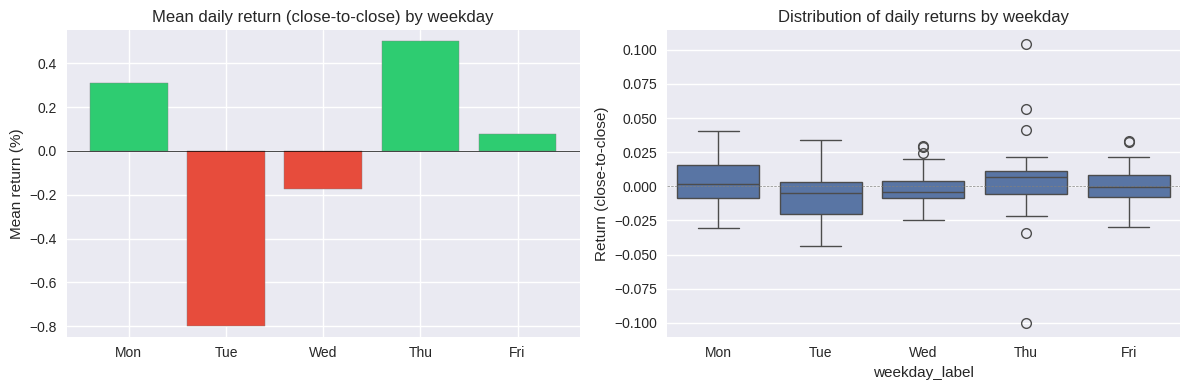

In [14]:
# Visualize: mean close-to-close return by weekday
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot: mean return by weekday
ax = axes[0]
weekday_order = [0, 1, 2, 3, 4]
labels = ["Mon", "Tue", "Wed", "Thu", "Fri"]
vals = [by_weekday.loc[d, "mean_return_cc"] if d in by_weekday.index else np.nan for d in weekday_order]
pct = [v * 100 if not np.isnan(v) else 0 for v in vals]
colors = ["#2ecc71" if v >= 0 else "#e74c3c" for v in vals]
ax.bar(labels, pct, color=colors, edgecolor="gray")
ax.axhline(0, color="black", linewidth=0.5)
ax.set_ylabel("Mean return (%)")
ax.set_title("Mean daily return (close-to-close) by weekday")
if pct:
    ax.set_ylim(min(min(pct) - 0.05, -0.5), max(max(pct) + 0.05, 0.5))

# Box plot: distribution of returns by weekday
ax = axes[1]
df_plot = df_ret.copy()
df_plot["weekday_label"] = df_plot["weekday"].map(dict(zip(weekday_order, labels)))
sns.boxplot(data=df_plot, x="weekday_label", y="return_close_to_close", order=labels, ax=ax)
ax.axhline(0, color="gray", linewidth=0.5, linestyle="--")
ax.set_ylabel("Return (close-to-close)")
ax.set_title("Distribution of daily returns by weekday")
plt.tight_layout()
plt.show()

In [15]:
# By ticker: Friday vs Monday mean returns (close-to-close)
fri_mon = df_ret[df_ret["weekday"].isin([0, 4])].copy()
fri_mon["dow"] = fri_mon["weekday"].map({0: "Monday", 4: "Friday"})
by_ticker_dow = fri_mon.groupby(["ticker", "dow"])["return_close_to_close"].mean().unstack()
by_ticker_dow["Fri_minus_Mon"] = by_ticker_dow["Friday"] - by_ticker_dow["Monday"]
by_ticker_dow = by_ticker_dow.round(4)
print("Mean close-to-close return by ticker and weekday:")
print(by_ticker_dow)
print("\nPositive Fri_minus_Mon = Friday return higher than Monday on average.")

Mean close-to-close return by ticker and weekday:
dow     Friday  Monday  Fri_minus_Mon
ticker                               
AAPL   -0.0018  0.0150        -0.0167
AMZN    0.0000  0.0094        -0.0093
GOOGL  -0.0001  0.0119        -0.0120
META   -0.0034  0.0006        -0.0040
MSFT    0.0026 -0.0028         0.0054
NVDA    0.0031 -0.0097         0.0128
TSLA    0.0051 -0.0027         0.0078

Positive Fri_minus_Mon = Friday return higher than Monday on average.


**Interpretation notes:**
- **Close-to-close return** on Monday includes the weekend (Fri close → Mon close); a "weekend effect" would show up as lower Monday mean return.
- **Same-day return** (open → close) isolates within-session moves: e.g. do prices tend to rise during Friday sessions and fall during Monday sessions?
- With limited history (e.g. a few weeks), results can be noisy; the weekend effect in the literature is often small and not always present in every sample.